# Houston Air Quality Data Exploration
____________________
### Patrick Huston, Ezra Varday, Charlie Owen | FA 2017

This notebook presents an initial exploration into the EPA air monitoring data for the Park Place AQ monitoring site in Houston, Texas.

##### Motivating Questions:
- What does air quality look like on an average day in Houston? 
- What are the seasonal dynamics of AQ in Houston? 
- Etc.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from windrose import WindroseAxes
import math

import warnings; warnings.simplefilter('ignore')

sns.set_style("darkgrid")

In [2]:
!ls ../data

338120170929155414557.txt 338120170929160847395.txt


In [3]:
filename = "../data/338120170929155414557.txt"

In [4]:
df1 = pd.read_csv(filename, skiprows=10, sep='|', usecols=[5,8,10,11,12], parse_dates={"Datetime" : [2,3]},dtype={'Value': np.int64})
df1.head()

,Datetime,Parameter Cd,Unit Cd,Value
0,2014-01-01 00:00:00,42101,7,0.16339
1,2014-01-01 01:00:00,42101,7,0.12578
2,2014-01-01 02:00:00,42101,7,0.13623
3,2014-01-01 03:00:00,42101,7,0.19557
4,2014-01-01 04:00:00,42101,7,0.24864


In [5]:
df1.set_index('Datetime').head()

,Parameter Cd,Unit Cd,Value
Datetime,,,
2014-01-01 00:00:00,42101,7,0.16339
2014-01-01 01:00:00,42101,7,0.12578
2014-01-01 02:00:00,42101,7,0.13623
2014-01-01 03:00:00,42101,7,0.19557
2014-01-01 04:00:00,42101,7,0.24864


### Parameter Breakdown

| Parameter Code | Meaning                    | Unit Code | Unit        |
|----------------|----------------------------|-----------|-------------|
| 42101          | Carbon dioxide             | 7         | ppm         |
| 42601          | Nitric oxide               | 8         | ppb         |
| 42602          | Nitrogen dioxide           | 8         | ppb         |
| 42603          | NOx                        | 8         | ppb         |
| 42201          | Ozone                      | 8         | ppb         |
| 61101          | Wind spd - scalar          | 12        | mph         |
| 61103          | Wind speed - resultant     | 12        | mph         |
| 61104          | Wind direction - resultant | 14        | deg comp.   |
| 61106          | Std. dev hz wind direction | 14        | deg comp.   |
| 62101          | Outdoor temperature        | 15        | Deg. F      |
| 62103          | Dew point                  | 15        | Deg. F      |
| 62201          | Humidity                   | 19        | % rel. hum  |
| 63301          | Solar radiation            | 25        | Lang/minute |
| 64101          | Barometric pressure        | 16        | Millibars   |

## Reading data

First, let's set up some utility functions and data structures to make better sense of the data. 

The `parameter_map` and `unit_map` fields will be used when generating plots to associate numerical codes with human-sensical strings.

`read_data` takes in a filename and returns a map of dataframes with key value pairs of (pollutant tracked, dataframe for that pollutant).

In [58]:
parameter_map = {
    42101: 'carbon_dioxide',
    42601: 'nitric_oxide',
    42602: 'nitrogen_dioxide',
    42603: 'nox',
    44201: 'ozone',
    61101: 'wind_spd_scalar',
    61103: 'wind_spd_resultant',
    61104: 'wind_dir_resultant',
    61106: 'std_dev_wind_dir',
    62101: 'outdoor_tmp',
    62103: 'dew_point',
    62201: 'humidity',
    63301: 'solar_radiation',
    64101: 'barometric_pressure'
}

unit_map = {
    7: 'ppm',
    8: 'ppb',
    12: 'mph',
    14: 'degrees compass',
    15: 'degrees F',
    19: 'percent rel. humidity',
    25: 'langley per min',
    16: 'millibars'
}

def unit_code_to_text(unit_code):
    return unit_map[unit_code]

def month_to_season(month):
    if month in [12,1,2]:
        return "winter"
    elif month in [3,4,5]:
        return "spring"
    elif month in [6,7,8]:
        return "summer"
    elif month in [9,10,11]:
        return "fall"


def read_data(filename):
    # Reads in data file, splits by parameter code, modifies dataframes with helpful features
    df1 = pd.read_csv(filename, 
                      skiprows=10, 
                      sep='|', 
                      usecols=[5,8,10,11,12], 
                      parse_dates={"Datetime" : [2,3]}, 
                      dtype={'Value': np.float32})
    
    all_dataframes = {}

    for parameter_code, parameter_name in parameter_map.iteritems():
        # Get all data for parameter code
        param_df = df1.loc[df1['Parameter Cd'] == parameter_code]
        param_df.index = param_df.Datetime
        param_df.sort_index(inplace=True)
        
        # Set helper fields for datetime breakdowns
        param_df['doy'] = param_df.index.dayofyear
        param_df['hour'] = param_df.index.hour
        param_df['woy'] = param_df.index.weekofyear
        param_df['month'] = param_df.index.month
        param_df['day'] = param_df.index.weekday
        param_df['season'] = param_df.month.apply(month_to_season)
        param_df['units'] = param_df['Unit Cd'].apply(unit_code_to_text)
        
        # Create extra helper fields
        param_mean = param_df.groupby('woy').Value.mean()
        param_df['annual_mean'] = param_mean[param_df.woy].values
        param_df['detrend'] = param_df.Value - param_df.annual_mean
        all_dataframes[parameter_name] = param_df
        param_df['{}_value'.format(parameter_name)] = param_df.Value
    
    return all_dataframes
    

In [59]:
all_data = read_data("../data/338120170929155414557.txt")

In [60]:
def plot_means(fields, group):
    fig = plt.figure(figsize=(12,8))
    for field in fields:
        plt.plot(all_data[field].groupby(group).Value.mean())
    plt.legend(fields, fontsize=14)
    plt.title("Pollutant Concentration averaged by Month", fontsize=16)
    plt.xlabel("Concentration (ppb)", fontsize=14)
    plt.ylabel("Month", fontsize=14)
    plt.show()

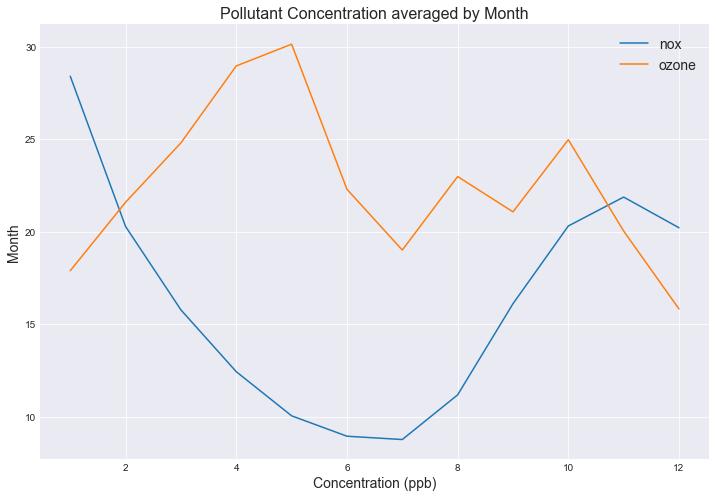

In [61]:
plot_means(['nox', 'ozone'], 'month')

In [111]:
def plot_means_seasonal(fields, group, figsize=(14,10)):
#     fig = plt.figure(figsize=figsize,sharey='col')
    f, (ax, bx) = plt.subplots(2,2,sharey='col',figsize=figsize)
    
    y_maxes = []
    y_mins  = []
    
    for i, season in enumerate(["winter", "spring", "summer", "fall"]):
        for field in fields:
            plt.subplot(2,2,i+1)
            plt.title(season.upper())
            plt.xlabel(group)
            plt.ylabel(all_data[field].units.iloc[0])
            season_data = all_data[field].loc[all_data[field]['season'] == season]
            season_grouped = season_data.groupby(group).Value.mean()
            y_maxes.append(max(season_grouped))
            y_mins.append(min(season_grouped))
            plt.plot(season_grouped)
    
    print y_maxes
    print y_mins
        
    # Normalize scales
    y_max = max(y_maxes) + .2*max(y_maxes)
    y_min = min(y_mins) - .2*min(y_mins)
    
    for i in range(1,5):
        ax = plt.subplot(2,2,i)
        ax.set_ylim([y_min, y_max])
            
    plt.show()

In [112]:
range(1,5)

[1, 2, 3, 4]

[29.275415, 50.801304, 40.046387, 30.982105, 37.422626, 27.265387, 40.68187, 47.09544]
[8.6449337, 12.725734, 14.251866, 8.3860722, 4.1607075, 6.1848946, 5.6229248, 8.8754683]


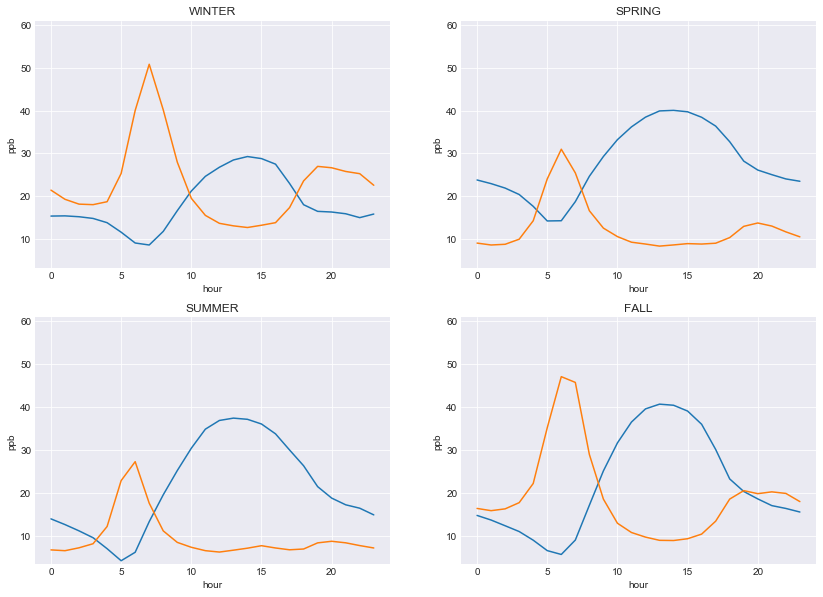

In [113]:
plot_means_seasonal(['ozone','nox'], 'hour')

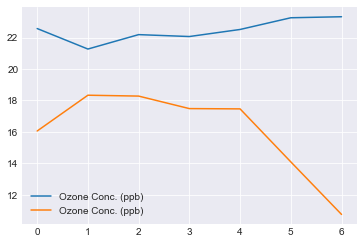

In [11]:
ozone_mean = all_data['ozone'].groupby('day').Value.mean()
nox_mean = all_data['nox'].groupby('day').Value.mean()
ozone_, = plt.plot(ozone_mean, label='Ozone Conc. (ppb)')
nox_, = plt.plot(nox_mean, label='Ozone Conc. (ppb)')
plt.legend(handles=[ozone_, nox_])
plt.show()

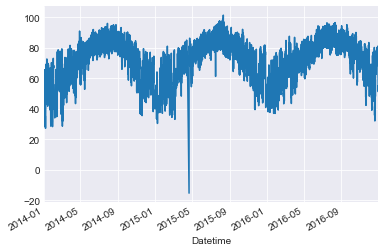

In [12]:
all_data['outdoor_tmp'].Value.plot()

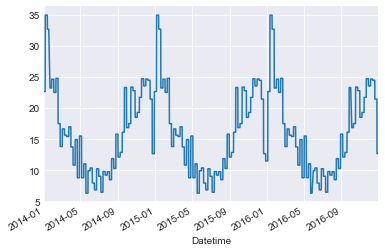

In [13]:
all_data['nox'].annual_mean.plot()

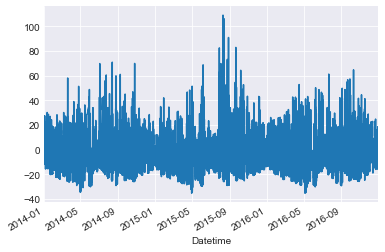

In [17]:
all_data['ozone'].detrend.plot()

In [15]:
def correlation(field_1, field_2):
    return all_data[field_1].detrend.corr(all_data[field_2].detrend)

In [16]:
correlation('ozone', 'solar_radiation')

0.54405058656598682

In [126]:
all_data['wind_dir_resultant'].describe()

,Parameter Cd,Unit Cd,Value,doy,hour,woy,month,day,season,annual_mean,detrend,wind_dir_resultant_value
count,25289.0,25289.0,25289.000000,25289.000000,25289.000000,25289.000000,25289.000000,25289.000000,25289.000000,25289.000000,2.528900e+04,25289.000000
mean,61104.0,14.0,154.792664,183.453280,11.512555,26.877733,6.534224,2.998656,6.534224,154.792664,-1.930805e-07,154.792664
std,0.0,0.0,92.046638,103.567866,6.922899,14.803335,3.395585,1.989831,3.395585,25.106926,8.855634e+01,92.046638
min,61104.0,14.0,0.009740,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,91.397377,-1.971067e+02,0.009740
25%,61104.0,14.0,88.952599,93.000000,6.000000,14.000000,4.000000,1.000000,4.000000,136.649551,-5.814639e+01,88.952599
50%,61104.0,14.0,163.210007,184.000000,12.000000,27.000000,7.000000,3.000000,7.000000,155.781677,1.925430e+00,163.210007
75%,61104.0,14.0,202.533005,272.000000,18.000000,40.000000,9.000000,5.000000,9.000000,178.372177,4.142955e+01,202.533005
max,61104.0,14.0,359.979004,365.000000,23.000000,53.000000,12.000000,6.000000,12.000000,201.607925,2.685786e+02,359.979004


In [40]:
# First, convert degrees to radians
# all_data['wind_dir_resultant']['wind_dir_resultant_value'] = all_data['wind_dir_resultant']['wind_dir_resultant_value'].apply(lambda x: math.radians(x))
 
wind_rose_types = ['wind_spd_resultant','wind_dir_resultant','ozone','carbon_dioxide','nitric_oxide','nitrogen_dioxide','nox']
wind_rose_data = [all_data[param].loc[:,['Datetime','{}_value'.format(param)]] for param in wind_rose_types]
wind_rose_merged = reduce(lambda  left,right: pd.merge(left,right,
                                            how='outer', left_index=True, right_index=True, copy=False), wind_rose_data)

wind_rose_merged = wind_rose_merged.drop(['Datetime_x', 'Datetime_y', 'Datetime'], axis=1)

wind_rose_merged.to_csv('~/Desktop/data.csv')


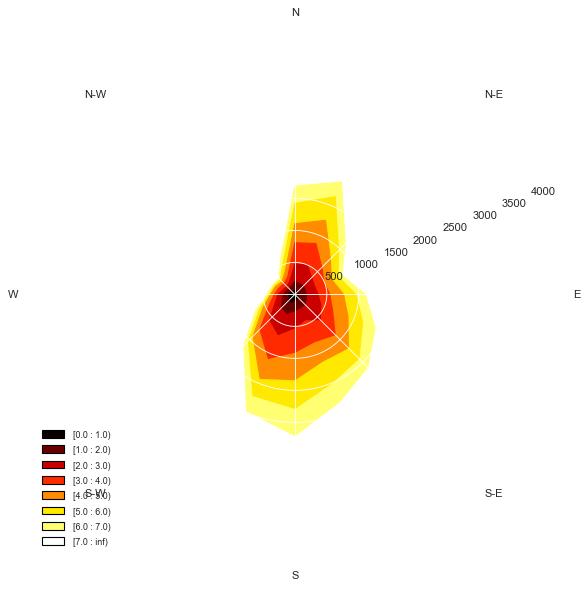

In [41]:
# Windrose exploration

ax = WindroseAxes.from_ax()
ax.contourf(wind_rose_merged.wind_dir_resultant_value, wind_rose_merged.wind_spd_resultant_value,bins=np.arange(0, 8, 1), cmap=cm.hot)
ax.set_legend()